# Assessment Rule Derivation
This notebook presents the procedure of assessment rule derivation for the maximum deflection of carbon concrete elements consistent with EC2

Based on section 7.4.2 of the EC2 (Nachweis der Begrenzung der Verformungen ohne direkte Berechnung; Cases where calculations may be omitted)

##### eq (7.16.a and 7.16.b): 

$$\dfrac{l}{d} = K.\left[11+1.5\sqrt{f_{ck}}\dfrac{\rho_0}{\rho} + 3.2\sqrt{f_{ck}}.\sqrt{\left(\dfrac{\rho_0}{\rho} - 1\right)^3}\right] \mathrm{if} \rho \leq \rho_0$$

$$ \dfrac{l}{d} = K.\left[11+1.5\sqrt{f_{ck}}\dfrac{\rho_0}{\rho- \rho^\prime} + \dfrac{1}{12}\sqrt[2]{f_{ck}}.\sqrt{(\dfrac{\rho^\prime}{\rho_0})}\right] \mathrm{if} \rho > \rho_0 $$

| Symbol | Unit | Description
| :-: | :-: | :- |
| $\dfrac{l}{d}$ | - | the limit value of the bending slenderness (ratio of span to effective height) |
| K | - | the coefficient for consideration of the different static systems according to Table 7.4N |
| $\rho_0$ | - | the reference reinforcement ratio, $\rho_0 = 10^{-3}.\sqrt{f_{ck}}$ |
| $\rho$ | - | the required ratio of tensile reinforcement in the center of the span to resist the design moment (at the restraint section for cantilever beams) |
| $\rho^\prime$ | - | the required ratio of compression reinforcement in the center of the span to resist the design moment (at the restraint section for cantilever beams) |
| $f_{ck}$ | Mpa | the Characteristic cylinder compressive strength of the concrete after 28 days |

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sympy import symbols
from sympy.plotting import plot
import sympy as sp
import numpy as np
import bmcs_utils.api as bu

In [2]:
K, rho_0, rho, rho_p, f_ck = symbols(r'K, \rho_0, \rho,\rho^\prime, f_{ck}', real=True, nonnegative=True)

In [3]:
ldr = sp.Piecewise(
     (K*(11 + 1.5*((f_ck)**0.5)*(rho_0/rho) + 3.2*((f_ck)**0.5)*((rho_0/rho - 1)**(3/2))) , rho <= rho_0 ),
     (K*(11 + 1.5*((f_ck)**0.5)*(rho_0/(rho - rho_p)) +  (1/12)*(f_ck**0.5)*((rho_p/rho_0)**0.5)) , rho > rho_0)
)
ldr

Piecewise((K*(3.2*f_{ck}**0.5*(-1 + \rho_0/\rho)**1.5 + 11 + 1.5*\rho_0*f_{ck}**0.5/\rho), \rho <= \rho_0), (K*(0.0833333333333333*\rho^\prime**0.5*\rho_0**(-0.5)*f_{ck}**0.5 + 1.5*\rho_0*f_{ck}**0.5/(\rho - \rho^\prime) + 11), True))

In [4]:
ldr = ldr.subs(rho_0, 0.001 * sp.sqrt(f_ck))
get_slenderness = sp.lambdify((rho, rho_p, K , f_ck), ldr, 'numpy')

In [5]:
import matplotlib.pyplot as plt
%matplotlib widget

rho_range = np.arange(0.0025, 0.025, 0.0001)
f_ck_range = (20, 30, 35, 40, 50, 70)

slenderness = []
for f_ck in f_ck_range:
    for rho in rho_range:
        slenderness.append(get_slenderness(rho, 0,  1, f_ck))
    plt.plot(rho_range*100, slenderness)
    slenderness = []

plt.ylim(10, 35)
plt.xlim(0.25, 2.5)
plt.ylabel('l/d')
plt.xlabel(r'$\rho$ %')
plt.title('7.16a & 7.16b curve')
plt.show()

<string>:2: RuntimeWarning: invalid value encountered in double_scalars


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars
<string>:2: RuntimeWarning: invalid value encountered in double_scalars


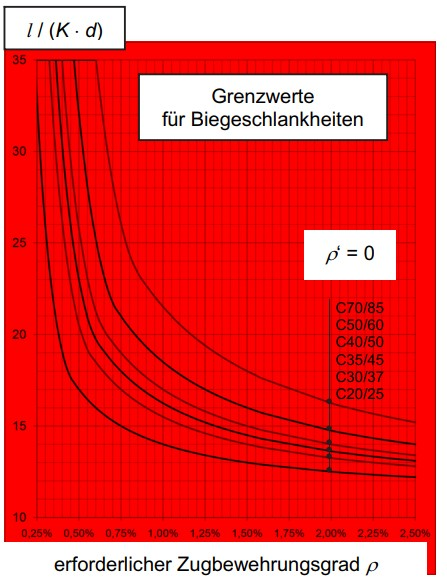

### Load-Deflection profle analysis

| Symbol | Unit | Description
| :-: | :-: | :- |
| $F_{s}$ | - | the SLS strength |
| $F_{u}$ | - | the strength between SLS limit and ULS |
| $w_{s}$ | - | the SLS deflection |
| $w_{u}$ | - | the deflection between SLS limit and ULS |  

In [6]:
from bmcs_cross_section.mkappa.mkappa import MKappa, ReinforcementType
from bmcs_cross_section.cs_design.cs_layout import Reinforcement
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions, BoundaryConfig
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu
from mpl_toolkits import mplot3d

def map_params(mc, B, H, eps_tu, E_cc, E_ct, eps_cr, eps_cy, mu, eps_cu):
    mc.cross_section_shape.B=B
    mc.cross_section_shape.H=H
    mc.E_cc=E_cc
    mc.E_ct=E_ct
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=eps_cy
    mc.eps_cu=eps_cu
    mc.eps_tu=eps_tu
    
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.cross_section_layout.reinforcement = [Reinforcement(
                                                eps_sy=f_sy / E_s, # or eps_sy_j=psi * eps_cr,
                                                E=E_s,
                                                z=h * (1 - alpha),
                                                A=rho * b * alpha * h)]

In [7]:
mc_params = dict(
            reinforcement_type= ReinforcementType.STEEL,
            n_m=100,
            n_kappa = 100,
            kappa_slider = 0.000001,
            low_kappa = 0,
            high_kappa =  0.00002, # 12e-6,
            eps_tu = 0.002508,
            E_cc = 34000,
            E_ct = 34000,
            eps_cr = 0.000132,
            eps_cy = 0.0015312,
            mu = 0.63,            # I changed this to zero
            eps_cu = 0.003498)

mc = MKappa(**mc_params)

b = 285
h = 299
mc.cross_section_shape.B = b
mc.cross_section_shape.H = h

mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=560/203000, E=203000, z=26.82, A=231.04)]

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 0
dp.beam_design.L = 3000

bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_shape,
                      dp.mc.cs_design.cross_section_layout,
                      mc.cross_section_layout.reinforcement], tight_layout=True).interact()

TraitError: Each element of the 'models' trait of an InteractiveWindow instance must be an IInteractiveModel or None, but a value of [<bmcs_cross_section.cs_design.cs_layout.Reinforcement object at 0x000001605B3C8168>] <class 'traits.trait_list_object.TraitListObject'> was specified.

In [8]:

from bmcs_cross_section.mkappa.mkappa import MKappa, ReinforcementType
from bmcs_cross_section.cs_design.cs_layout import Reinforcement
from bmcs_beam.beam_config.boundary_conditions import BoundaryConfig
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu
mc_params = dict(
            reinforcement_type= ReinforcementType.STEEL,
            n_m=100,
            n_kappa = 100,
            kappa_slider = 0.000001,
            low_kappa = 0,
            high_kappa =  0.00002, 
            eps_tu = 0.002508,
            E_cc = 34000,
            E_ct = 34000,
            eps_cr = 0.000132,
            eps_cy = 0.0015312,
            mu = 0.63,            
            eps_cu = 0.003498)
mc = MKappa(**mc_params)
b = 285
h = 29
mc.cross_section_shape.B = b
mc.cross_section_shape.H = h
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=560/203000,\
E=203000, z=26.82, A=231.04)]
dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 0
dp.beam_design.L = 3000
%matplotlib widget
bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_layout,
                      dp.mc.cs_design.cross_section_shape,
                      dp.mc.cross_section_layout.matrix,
                      dp.mc.cross_section_layout],
                      tight_layout=True).interact()

d:\imb\pycharm_workspace\bmcs_utils\bmcs_utils\interactive_window.py:108: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  self.fig.canvas.draw()


In [9]:
rho_range_steel = np.linspace(0.0025, 0.025, 6)
slenderness_range_steel = np.linspace(10, 35, 6)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_steel, sl_grid_steel = np.meshgrid(rho_range_steel, slenderness_range_steel) 
F_u_grid_steel = np.zeros_like(rho_grid_steel)
F_s_grid_steel = np.zeros_like(rho_grid_steel)

_ , ax = plt.subplots()
ax.set_xlabel(r'$w$ [mm]')
ax.set_ylabel(r'$F$ [KN]')
        
for sl_idx in range(0,len(slenderness_range_steel)):
    for rho_idx in range(0,len(rho_range_steel)):      
        rho = rho_grid_steel[rho_idx, sl_idx]
        sl = sl_grid_steel[rho_idx, sl_idx]

        print('parameter combination', rho, sl)

        # assigning the grid area (area_g) to the reinforcement area variable
        A_j_g = rho * area_g
        dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

        # assigning the grid length (L_g) to the beam length variable
        L_g = sl * d
        dp.beam_design.L = L_g

        # running the deflection analysis 
        F_data, w_data = dp.get_Fw()
        
        # plotting, post-processing & saving the data
        ax.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
        
        w_s = dp.beam_design.L / 250
        w_max = max(w_data)
        w_u = max(w_data) - w_s
        F_s = np.interp(w_s, w_data, F_data)
        F_u = max(F_data)

        F_u_grid_steel[rho_idx,sl_idx] = F_u
        F_s_grid_steel[rho_idx,sl_idx] = F_s

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

parameter combination 0.0025 10.0
parameter combination 0.0025 15.0
parameter combination 0.0025 20.0
parameter combination 0.0025 25.0


KeyboardInterrupt: 

In [ ]:
# np.save('F_u_grid_steel_with_material_factors.npy', F_u_grid)
# np.save('F_s_grid_steel_with_material_factors.npy', F_s_grid)
np.save('F_u_grid_steel.npy', F_u_grid_steel)
np.save('F_s_grid_steel.npy', F_s_grid_steel)

In [12]:
# This cell is for loading results later if needed
rho_range_steel = np.linspace(0.0025, 0.025, 6)
slenderness_range_steel = np.linspace(10, 35, 6)
rho_grid_steel, sl_grid_steel = np.meshgrid(rho_range_steel, slenderness_range_steel) 
F_u_grid_steel = np.load('F_u_grid_steel.npy')
F_s_grid_steel = np.load('F_s_grid_steel.npy')

In [13]:
_, ax = plt.subplots(1,1)
# z = F_u_grid/F_s_grid -1
z = (F_s_grid_steel + F_u_grid_steel) / F_s_grid_steel - 1.65

CS = ax.contour(rho_grid_steel, sl_grid_steel, z , levels=[0.])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('L/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(10, 35)
ax.set_xlim(0.0025, 0.025)

# Draw C50 curve
rho_range = np.arange(0.0025, 0.025, 0.0001)
f_ck = 50
slenderness = []
for rho in rho_range:
    slenderness.append(get_slenderness(rho, 0,  1, f_ck))
ax.plot(rho_range, slenderness)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: Shapes of x (6, 6) and z (10, 10) do not match

## Testing for Carbon
#### 1. Verification with Heid et al. (2020), [link](https://www.heringinternational.com/fileadmin/media/archive1/downloads/architekturbeton/Bauingenieur_06_2020_S.210-219.pdf), Carbon reinforcement


In [160]:
# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

%matplotlib widget
bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_shape, 
                      dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

d:\imb\pycharm_workspace\bmcs_utils\bmcs_utils\interactive_window.py:108: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  self.fig.canvas.draw()


In [11]:
M_x = dp.beam_design.get_M_x()
len(M_x)
print(M_x[:int(len(M_x)/2)])

[     0.           5516.18968396  11032.37936791  16548.56905187
  22064.75873582  27580.94841978  33097.13810374  38613.32778769
  44129.51747165  49645.7071556   55161.89683956  60678.08652352
  66194.27620747  71710.46589143  77226.65557538  82742.84525934
  88259.0349433   93775.22462725  99291.41431121 104807.60399517
 110323.79367912 115839.98336308 121356.17304703 126872.36273099
 132388.55241495 137904.7420989  143420.93178286 148937.12146681
 154453.31115077 159969.50083473 165485.69051868 171001.88020264
 176518.06988659 182034.25957055 187550.44925451 193066.63893846
 198582.82862242 204099.01830637 208039.15379491 208039.15379491
 208039.15379491 208039.15379491 208039.15379491 208039.15379491
 208039.15379491 208039.15379491 208039.15379491 208039.15379491
 208039.15379491 208039.15379491]


In [164]:
%matplotlib widget
L_mid_SLS_inx = 200
L_inx = (dp.beam_design.L - L_mid_SLS_inx)/2
x_inx = round(L_inx*len(dp.beam_design.x)/dp.beam_design.L)
W_x = dp.get_w_x()
y = dp.beam_design.x
point = round(len(W_x)/3)
# print(W_x[:int(len(W_x)/2)])
plt.plot(y,W_x, 'r.', y[x_inx], W_x[x_inx], 'b*',y[-x_inx-1], W_x[-x_inx-1], 'b*')
min(W_x)
print('len',len(W_x))
print('index',x_inx)
dp.beam_design.L/100 * len(W_x)
print(y[x_inx],y[-x_inx-1],L_inx)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

len 100
index 38
322.4242424242424 517.5757575757575 320.0


In [228]:
%matplotlib widget
# running the deflection analysis 
L_mid_SLS_inx = 200
L_inx = (dp.beam_design.L - L_mid_SLS_inx)/2
x_inx = round(L_inx*len(dp.beam_design.x)/dp.beam_design.L)
mc.cross_section_shape.B = 30
dp.beam_design.L = 840

_, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10)) 
ax1.plot(y,W_x, 'r.', y[x_inx], W_x[x_inx], 'b*',y[-x_inx-1], W_x[-x_inx-1], 'b*')

F_data_inx, w_data_inx = dp.get_Fw_inx(x_inx)
F_data, w_data = dp.get_Fw()
# print(F_data.size, w_data.shape)
# plotting, post-processing & saving the data
m = np.diff(w_data)/np.diff(F_data/1000)
a = np.diff(np.round(m))
ans = np.argmax(m)
w_data[ans+1]

m_inx = np.diff(w_data_inx)/np.diff(F_data_inx/1000)
a_inx = np.diff(np.round(m_inx))
ans_inx = np.argmax(m_inx)
w_data[ans_inx+1]

w_s = dp.beam_design.L / 250
w_max = max(w_data)
w_u = max(w_data) - w_s
F_s = np.interp(w_s, w_data, F_data)
F_u = max(F_data)

eta = F_u / F_s
xi = w_u/w_s

ax2.plot(w_data, F_data/1000, 'r-', w_data_inx, F_data_inx/1000, 'b-.',\
          w_data[ans+1], F_data[ans+1]/1000, 'b.', w_data[ans], F_data[ans]/1000, 'b.',\
          w_data_inx[ans_inx+1], F_data_inx[ans_inx+1]/1000, 'r.', w_data_inx[ans_inx], F_data_inx[ans_inx]/1000, 'r.')

ax2.plot([dp.beam_design.L/250,dp.beam_design.L/250], [0,max(F_data/1000)], c= 'gray', ls = '--')
ax2.annotate("eta={}  xi={} ".format(round(eta, 2), round(xi, 2)), (dp.beam_design.L / 250 * 1.4, F_data[ans+1]/1000*0.675),\
            bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax2.annotate('L/250', (dp.beam_design.L / 250*1.01 , F_data[ans+1]/2/1000),\
             fontsize=12, rotation = 'vertical')
ax2.set_xlabel(r'$w$ [mm]')
ax2.set_ylabel(r'$F$ [KN]')
# ax2.set_xlim(0,dp.beam_design.L / 250*1.25)
# ax2.set_ylim(0,F_data[ans+1]/1000*1.25)
ax2.legend(['Deflection at the middle of the beam','Deflection at L={}'.format(L_inx)], loc=0)

if w_data[ans+1]>dp.beam_design.L/250:
    print('not passed')
else:
    print('passed')
    
alpha = (w_data[ans+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
beta = ((dp.beam_design.L / 250 - w_data[ans+1]) / w_data[ans+1]) + 1     #a coefficientto provide b for the next iteration
# print('alpha, beta', alpha, beta)

alpha_inx = (w_data_inx[ans_inx+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
beta_inx = ((dp.beam_design.L / 250 - w_data_inx[ans_inx+1]) / w_data_inx[ans_inx+1]) + 1     #a coefficientto provide b for the next iteration
# print('alpha_inx, beta_inx', alpha_inx, beta_inx)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

not passed


31 (31,)


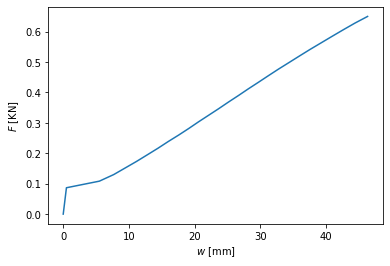

In [22]:
# running the deflection analysis 
F_data_inx, w_data_inx = dp.get_Fw_inx(49)
F_data_inx, w_data_inx = dp.get_Fw()

print(F_data.size, w_data.shape)
# plotting, post-processing & saving the data
plt.plot(w_data_inx, F_data_inx/1000, 'b-', )
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')
plt.show()

# f, w = dp.get_Fw_inx(self, 10)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18],dtype=np.float)
y = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 14,14,14,14,14,14,14,20,26],dtype=np.float)
plt.scatter(x,y)
print(len(x), len(y))

In [ ]:
m = np.diff(y)/np.diff(x)
print (m)

In [ ]:
a = np.diff(m)
a

In [ ]:
i = np.nonzero(a)
i

In [ ]:
i_ = i + np.ones_like(i)
i_

In [ ]:
print(y[i],x[i])

In [ ]:
plt.plot(x,y,'r--',x[i_],y[i_],'bs')


In [ ]:
dp.beam_design.get_M_x(100)

In [ ]:
%matplotlib widget
m = np.diff(w_data)/np.diff(F_data/1000)
a = np.diff(np.round(m))
ans = np.argmax(m)
w_data[ans+1]

plt.plot(w_data, F_data/1000, 'r-', w_data[ans+1], F_data[ans+1]/1000, 'b.', w_data[ans], F_data[ans]/1000, 'b.')
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')
plt.show()
print( w_data[ans+1])
print (dp.beam_design.L/250)

In [ ]:
%matplotlib widget
f_ck = 72

# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840


rho_range_carbon = np.linspace(0.0025, 0.025, 1)
slenderness_range_carbon = np.linspace(20, 35, 1)
b = mc.cross_section_shape.B
b_range_carbon = np.linspace(b, b*2, 3)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon) 

F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for sl_idx in range(0,len(slenderness_range_carbon)):
    for rho_idx in range(0,len(rho_range_carbon)):
        for b in b_range_carbon:

            ''' concrete specifications'''

            #E_cm from Table 3.1 of EC2 1992.1.1.2004
            E = 22*((f_ck+8)/10)**0.3

            #e_c3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cy = sp.Piecewise(
                                (1.75, f_ck < 50),
                                ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
            )

            #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cu = sp.Piecewise(
                                (3.5, f_ck < 50),
                                ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
            )

            #eps_cr = ?
            eps_cr = 0.000163

            #f_ctm from Table 3.1 of EC2 1992.1.1.2004
            f_ctm = sp.Piecewise(
                                (0.3*f_ck**(2/3), f_ck < 50),
                                ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
            )

            mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                        low_kappa = 0,
                        high_kappa = 0.0007,
                        E_cc = E,
                        E_ct = E,
                        eps_cr = eps_cr,
                        eps_tu = f_ctm/E, 
                        eps_cy = eps_cy,
                        eps_cu = eps_cu,
                        mu = 0.0)
                               
                
            rho = rho_grid_carbon[rho_idx, sl_idx]
            sl = sl_grid_carbon[rho_idx, sl_idx]
            
            # assigning the grid area (area_g) to the reinforcement area variable
#             A_j_g = rho * area_g
#             dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()
#             print('parameter combination', rho, sl)
            # finding the stress transition point
            m = np.diff(w_data)/np.diff(F_data/1000)
            a = np.diff(np.round(m))
            ans = np.argmax(m)
            
            alpha = (w_data[ans+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
            beta = ((dp.beam_design.L / 250 - w_data[ans+1]) / w_data[ans+1]) + 1     #a coefficientto provide b for the next iteration
            print('w_data[ans+1]',w_data[ans+1],'L / 250',dp.beam_design.L / 250,\
                  'b',b, 'b*beta',b*beta, 'alpha',alpha, 'beta',beta)
            
#             if alpha > 1:
#                 mc.cross_section_shape.B = b * beta
#                 # running the deflection analysis 
#                 F_data, w_data = dp.get_Fw()
#                 print('parameter combination', rho, sl)
#                 # finding the stress transition point
#                 m = np.diff(w_data)/np.diff(F_data/1000)
#                 a = np.diff(np.round(m))
#                 ans = np.argmax(m)

#                 alpha = (w_data[ans+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
#                 beta = (dp.beam_design.L / 250 - w_data[ans+1]) / w_data[ans+1] + 1     #a coefficientto provide b for the next iteration
            
#                 if alpha <= 0.5:
#                     print('parameter combination', rho, sl, b, alpha)
#                     break
                    
                    

#                     print(alpha, beta)
#                     # plotting, post-processing & saving the data
#                     plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
#                     plt.xlabel(r'$w$ [mm]')
#                     plt.ylabel(r'$F$ [KN]')
#                     plt.show()

#                     w_s = dp.beam_design.L / 250
#                     w_max = max(w_data)
#                     w_u = max(w_data) - w_s
#                     F_s = np.interp(w_s, w_data, F_data)
#                     F_max = max(F_data)
#                     F_u = max(F_data) - F_s

#                     F_u_grid_carbon[rho_idx,sl_idx] = F_u
#                     F_s_grid_carbon[rho_idx,sl_idx] = F_s

In [ ]:
%matplotlib widget

rho_range_carbon = np.linspace(0.0025, 0.025, 1)
slenderness_range_carbon = np.linspace(20, 35, 1)
fck_range_carbon = np.linspace(70, 50, 1)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon, fck_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon, fck_range_carbon) 
# fck_grid_carbon, fck_grid_carbon = np.meshgrid(fck_range_carbon, fck_range_carbon) 
F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for fc_idx in range(0,len(fck_range_carbon)):
    for sl_idx in range(0,len(slenderness_range_carbon)):
        for rho_idx in range(0,len(rho_range_carbon)):

            ''' concrete specifications'''

            #E_cm from Table 3.1 of EC2 1992.1.1.2004
            E = 22*((f_ck+8)/10)**0.3

            #e_c3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cy = sp.Piecewise(
                                (1.75, f_ck < 50),
                                ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
            )

            #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cu = sp.Piecewise(
                                (3.5, f_ck < 50),
                                ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
            )

            #eps_cr = ?
            eps_cr = 0.000163

            #f_ctm from Table 3.1 of EC2 1992.1.1.2004
            f_ctm = sp.Piecewise(
                                (0.3*f_ck**(2/3), f_ck < 50),
                                ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
            )

            mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                        low_kappa = 0,
                        high_kappa = 0.0007,
                        E_cc = E,
                        E_ct = E,
                        eps_cr = eps_cr,
                        eps_tu = f_ctm/E, 
                        eps_cy = eps_cy,
                        eps_cu = eps_cu,
                        mu = 0.0)


            rho = rho_grid_carbon[rho_idx, sl_idx, fc_idx]
            sl = sl_grid_carbon[rho_idx, sl_idx, fc_idx]
            f_ck = fck_grid_carbon[rho_idx, sl_idx, fc_idx]
            print('parameter combination', rho, sl, f_ck)

            # assigning the grid area (area_g) to the reinforcement area variable
            A_j_g = rho * area_g
            dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()
            print(F_data.size, w_data.shape)
            # plotting, post-processing & saving the data
            plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
            plt.xlabel(r'$w$ [mm]')
            plt.ylabel(r'$F$ [KN]')
            plt.show()

            w_s = dp.beam_design.L / 250
            w_max = max(w_data)
            w_u = max(w_data) - w_s
            F_s = np.interp(w_s, w_data, F_data)
            F_max = max(F_data)
            F_u = max(F_data) - F_s

            F_u_grid_carbon[rho_idx,sl_idx] = F_u
            F_s_grid_carbon[rho_idx,sl_idx] = F_s

In [122]:
%matplotlib widget
f_ck = 72

# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840


rho_range_carbon = np.linspace(0.0025, 0.025, 1)
slenderness_range_carbon = np.linspace(20, 35, 1)
b = mc.cross_section_shape.B
b_range_carbon = np.linspace(b, b*2, 3)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon) 

F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for sl_idx in range(0,len(slenderness_range_carbon)):
    for rho_idx in range(0,len(rho_range_carbon)):
        for b in b_range_carbon:

            ''' concrete specifications'''

            #E_cm from Table 3.1 of EC2 1992.1.1.2004
            E = 22*((f_ck+8)/10)**0.3

            #e_c3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cy = sp.Piecewise(
                                (1.75, f_ck < 50),
                                ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
            )

            #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cu = sp.Piecewise(
                                (3.5, f_ck < 50),
                                ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
            )

            #eps_cr = ?
            eps_cr = 0.000163

            #f_ctm from Table 3.1 of EC2 1992.1.1.2004
            f_ctm = sp.Piecewise(
                                (0.3*f_ck**(2/3), f_ck < 50),
                                ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
            )

            mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                        low_kappa = 0,
                        high_kappa = 0.0007,
                        E_cc = E,
                        E_ct = E,
                        eps_cr = eps_cr,
                        eps_tu = f_ctm/E, 
                        eps_cy = eps_cy,
                        eps_cu = eps_cu,
                        mu = 0.0)
                               
                
            rho = rho_grid_carbon[rho_idx, sl_idx]
            sl = sl_grid_carbon[rho_idx, sl_idx]
            
            # assigning the grid area (area_g) to the reinforcement area variable
#             A_j_g = rho * area_g
#             dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()
#             print('parameter combination', rho, sl)
            # finding the stress transition point
            m = np.diff(w_data)/np.diff(F_data/1000)
            a = np.diff(np.round(m))
            ans = np.argmax(m)
            
            alpha = (w_data[ans+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
            beta = ((dp.beam_design.L / 250 - w_data[ans+1]) / w_data[ans+1]) + 1     #a coefficientto provide b for the next iteration
            print('w_data[ans+1]',w_data[ans+1],'L / 250',dp.beam_design.L / 250,\
                  'b',b, 'b*beta',b*beta, 'alpha',alpha, 'beta',beta)
            
#             if alpha > 1:
#                 mc.cross_section_shape.B = b * beta
#                 # running the deflection analysis 
#                 F_data, w_data = dp.get_Fw()
#                 print('parameter combination', rho, sl)
#                 # finding the stress transition point
#                 m = np.diff(w_data)/np.diff(F_data/1000)
#                 a = np.diff(np.round(m))
#                 ans = np.argmax(m)

#                 alpha = (w_data[ans+1]) / (dp.beam_design.L / 250)     #an index for the difference of existing limit and the L/250
#                 beta = (dp.beam_design.L / 250 - w_data[ans+1]) / w_data[ans+1] + 1     #a coefficientto provide b for the next iteration
            
#                 if alpha <= 0.5:
#                     print('parameter combination', rho, sl, b, alpha)
#                     break
                    
                    

#                     print(alpha, beta)
#                     # plotting, post-processing & saving the data
#                     plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
#                     plt.xlabel(r'$w$ [mm]')
#                     plt.ylabel(r'$F$ [KN]')
#                     plt.show()

#                     w_s = dp.beam_design.L / 250
#                     w_max = max(w_data)
#                     w_u = max(w_data) - w_s
#                     F_s = np.interp(w_s, w_data, F_data)
#                     F_max = max(F_data)
#                     F_u = max(F_data) - F_s

#                     F_u_grid_carbon[rho_idx,sl_idx] = F_u
#                     F_s_grid_carbon[rho_idx,sl_idx] = F_s

w_data[ans+1] 1.4980221456351297 L / 250 1.76 b 45.0 b*beta 52.869712394285656 alpha 0.8511489463835964 beta 1.1748824976507923
w_data[ans+1] 1.4980221456351297 L / 250 1.76 b 67.5 b*beta 79.30456859142848 alpha 0.8511489463835964 beta 1.1748824976507923
w_data[ans+1] 1.4980221456351297 L / 250 1.76 b 90.0 b*beta 105.73942478857131 alpha 0.8511489463835964 beta 1.1748824976507923


In [ ]:
%matplotlib widget

rho_range_carbon = np.linspace(0.0025, 0.025, 1)
slenderness_range_carbon = np.linspace(20, 35, 1)
fck_range_carbon = np.linspace(70, 50, 1)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon, fck_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon, fck_range_carbon) 
# fck_grid_carbon, fck_grid_carbon = np.meshgrid(fck_range_carbon, fck_range_carbon) 
F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for fc_idx in range(0,len(fck_range_carbon)):
    for sl_idx in range(0,len(slenderness_range_carbon)):
        for rho_idx in range(0,len(rho_range_carbon)):

            ''' concrete specifications'''

            #E_cm from Table 3.1 of EC2 1992.1.1.2004
            E = 22*((f_ck+8)/10)**0.3

            #e_c3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cy = sp.Piecewise(
                                (1.75, f_ck < 50),
                                ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
            )

            #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cu = sp.Piecewise(
                                (3.5, f_ck < 50),
                                ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
            )

            #eps_cr = ?
            eps_cr = 0.000163

            #f_ctm from Table 3.1 of EC2 1992.1.1.2004
            f_ctm = sp.Piecewise(
                                (0.3*f_ck**(2/3), f_ck < 50),
                                ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
            )

            mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                        low_kappa = 0,
                        high_kappa = 0.0007,
                        E_cc = E,
                        E_ct = E,
                        eps_cr = eps_cr,
                        eps_tu = f_ctm/E, 
                        eps_cy = eps_cy,
                        eps_cu = eps_cu,
                        mu = 0.0)


            rho = rho_grid_carbon[rho_idx, sl_idx, fc_idx]
            sl = sl_grid_carbon[rho_idx, sl_idx, fc_idx]
            f_ck = fck_grid_carbon[rho_idx, sl_idx, fc_idx]
            print('parameter combination', rho, sl, f_ck)

            # assigning the grid area (area_g) to the reinforcement area variable
            A_j_g = rho * area_g
            dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()
            print(F_data.size, w_data.shape)
            # plotting, post-processing & saving the data
            plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
            plt.xlabel(r'$w$ [mm]')
            plt.ylabel(r'$F$ [KN]')
            plt.show()

            w_s = dp.beam_design.L / 250
            w_max = max(w_data)
            w_u = max(w_data) - w_s
            F_s = np.interp(w_s, w_data, F_data)
            F_max = max(F_data)
            F_u = max(F_data) - F_s

            F_u_grid_carbon[rho_idx,sl_idx] = F_u
            F_s_grid_carbon[rho_idx,sl_idx] = F_s

In [ ]:
m = np.diff(y)/np.diff(x)
print (m)

In [ ]:
a = np.diff(m)
a

In [ ]:
i = np.nonzero(a)
i

In [ ]:
i_ = i + np.ones_like(i)
i_

In [ ]:
print(y[i],x[i])

In [ ]:
plt.plot(x,y,'r--',x[i_],y[i_],'bs')


In [ ]:
%matplotlib inline
# running the deflection analysis 
mc.cross_section_shape.B = 10

F_data, w_data = dp.get_Fw()
# print(F_data.size, w_data.shape)
# plotting, post-processing & saving the data
%matplotlib widget
m = np.diff(w_data)/np.diff(F_data/1000)
a = np.diff(np.round(m))
ans = np.argmax(m)
w_data[ans+1]

plt.plot(w_data, F_data/1000, 'r-', w_data[ans+1], F_data[ans+1]/1000, 'b.', w_data[ans], F_data[ans]/1000, 'b.')
plt.plot([dp.beam_design.L/250,dp.beam_design.L/250], [0,max(F_data/1000)])
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')
plt.show()
if w_data[ans+1]>dp.beam_design.L/250:
    print('not passed')
else:
    print('passed')

In [ ]:
%matplotlib widget
m = np.diff(w_data)/np.diff(F_data/1000)
a = np.diff(np.round(m))
ans = np.argmax(m)
w_data[ans+1]

plt.plot(w_data, F_data/1000, 'r-', w_data[ans+1], F_data[ans+1]/1000, 'b.', w_data[ans], F_data[ans]/1000, 'b.')
plt.xlabel(r'$w$ [mm]')
plt.ylabel(r'$F$ [KN]')
plt.show()
print( w_data[ans+1])
print (dp.beam_design.L/250)

In [ ]:
%matplotlib widget

rho_range_carbon = np.linspace(0.0025, 0.025, 1)
slenderness_range_carbon = np.linspace(20, 35, 1)
fck_range_carbon = np.linspace(70, 50, 1)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon, fck_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon, fck_range_carbon) 
# fck_grid_carbon, fck_grid_carbon = np.meshgrid(fck_range_carbon, fck_range_carbon) 
F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for fc_idx in range(0,len(fck_range_carbon)):
    for sl_idx in range(0,len(slenderness_range_carbon)):
        for rho_idx in range(0,len(rho_range_carbon)):

            ''' concrete specifications'''

            #E_cm from Table 3.1 of EC2 1992.1.1.2004
            E = 22*((f_ck+8)/10)**0.3

            #e_c3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cy = sp.Piecewise(
                                (1.75, f_ck < 50),
                                ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
            )

            #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
            eps_cu = sp.Piecewise(
                                (3.5, f_ck < 50),
                                ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
            )

            #eps_cr = ?
            eps_cr = 0.000163

            #f_ctm from Table 3.1 of EC2 1992.1.1.2004
            f_ctm = sp.Piecewise(
                                (0.3*f_ck**(2/3), f_ck < 50),
                                ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
            )

            mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                        low_kappa = 0,
                        high_kappa = 0.0007,
                        E_cc = E,
                        E_ct = E,
                        eps_cr = eps_cr,
                        eps_tu = f_ctm/E, 
                        eps_cy = eps_cy,
                        eps_cu = eps_cu,
                        mu = 0.0)


            rho = rho_grid_carbon[rho_idx, sl_idx, fc_idx]
            sl = sl_grid_carbon[rho_idx, sl_idx, fc_idx]
            f_ck = fck_grid_carbon[rho_idx, sl_idx, fc_idx]
            print('parameter combination', rho, sl, f_ck)

            # assigning the grid area (area_g) to the reinforcement area variable
            A_j_g = rho * area_g
            dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

            # assigning the grid length (L_g) to the beam length variable
            L_g = sl * d
            dp.beam_design.L = L_g

            # running the deflection analysis 
            F_data, w_data = dp.get_Fw()
            print(F_data.size, w_data.shape)
            # plotting, post-processing & saving the data
            plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
            plt.xlabel(r'$w$ [mm]')
            plt.ylabel(r'$F$ [KN]')
            plt.show()

            w_s = dp.beam_design.L / 250
            w_max = max(w_data)
            w_u = max(w_data) - w_s
            F_s = np.interp(w_s, w_data, F_data)
            F_max = max(F_data)
            F_u = max(F_data) - F_s

            F_u_grid_carbon[rho_idx,sl_idx] = F_u
            F_s_grid_carbon[rho_idx,sl_idx] = F_s

In [ ]:
%matplotlib widget
# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

rho_range_carbon = np.linspace(0.00, 0.025, 5)
slenderness_range_carbon = np.linspace(5, 70, 5)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, sl_grid_carbon = np.meshgrid(rho_range_carbon, slenderness_range_carbon) 
F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)

w_u_grid_carbon = np.zeros_like(rho_grid_carbon)
w_s_grid_carbon = np.zeros_like(rho_grid_carbon)


for sl_idx in range(0,len(slenderness_range_carbon)):
    for rho_idx in range(0,len(rho_range_carbon)):

        ''' concrete specifications'''

        #E_cm from Table 3.1 of EC2 1992.1.1.2004
        E = 22*((f_ck+8)/10)**0.3

        #e_c3 from Table 3.1 of EC2 1992.1.1.2004
        eps_cy = sp.Piecewise(
                            (1.75, f_ck < 50),
                            ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
        )

        #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
        eps_cu = sp.Piecewise(
                            (3.5, f_ck < 50),
                            ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
        )

        #eps_cr = ?
        eps_cr = 0.000163

        #f_ctm from Table 3.1 of EC2 1992.1.1.2004
        f_ctm = sp.Piecewise(
                            (0.3*f_ck**(2/3), f_ck < 50),
                            ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
        )

        mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                    low_kappa = 0,
                    high_kappa = 0.0007,
                    E_cc = E,
                    E_ct = E,
                    eps_cr = eps_cr,
                    eps_tu = f_ctm/E, 
                    eps_cy = eps_cy,
                    eps_cu = eps_cu,
                    mu = 0.0)


        rho = rho_grid_carbon[rho_idx, sl_idx]
        sl = sl_grid_carbon[rho_idx, sl_idx]

        print('parameter combination', rho, sl)

        # assigning the grid area (area_g) to the reinforcement area variable
        A_j_g = rho * area_g
        dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

        # assigning the grid length (L_g) to the beam length variable
        L_g = sl * d
        dp.beam_design.L = L_g

        # running the deflection analysis 
        F_data, w_data = dp.get_Fw()
        print(F_data.size, w_data.shape)
        # plotting, post-processing & saving the data
        plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, sl))
        plt.xlabel(r'$w$ [mm]')
        plt.ylabel(r'$F$ [KN]')
        plt.show()

        w_s = dp.beam_design.L / 250
        w_max = max(w_data)
        w_u = max(w_data) - w_s
        F_s = np.interp(w_s, w_data, F_data)
        F_max = max(F_data)
        F_u = max(F_data) - F_s

        F_u_grid_carbon[rho_idx,sl_idx] = F_u
        F_s_grid_carbon[rho_idx,sl_idx] = F_s
        
        w_u_grid_carbon[rho_idx,sl_idx] = w_u
        w_s_grid_carbon[rho_idx,sl_idx] = w_s

In [ ]:
_, ax = plt.subplots(1,1)

z = (F_s_grid_carbon + F_u_grid_carbon) / F_s_grid_carbon - 6.3

CS = ax.contour(rho_grid_carbon, sl_grid_carbon, z) #, levels=[0])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('l/d')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(5, 80)
ax.set_xlim(0.000, 0.025)

# Draw C72 curve
rho_range = np.arange(0, 0.05, 0.0001)
f_ck = 72
slenderness = []
for rho in rho_range:
    slenderness.append(get_slenderness(rho, 0,  1, f_ck))
ax.plot(rho_range, slenderness)

In [ ]:
%matplotlib widget
# Testing for Carbon
# HB-SU-0
E = 39500

# from bending test from σ_c,Riss
eps_cr = ((6.365 + 6.306 + 5.635 + 5.627 + 5.452 + 5.627)/6)/E

mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
            low_kappa = 0,
            high_kappa = 0.0007,
            E_cc = E,
            E_ct = E,
            eps_cr = eps_cr, # 0.000163
            eps_tu = 9.02/E, # beta_tu = 20
            eps_cy = 72/E, # omega = 10.0
            eps_cu = (72/E)*2, # lambda_cu = 20
            mu = 0.0)

mc.cross_section_shape.B = 45
mc.cross_section_shape.H = 30
mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=2712/240000, E=240000, z=8, A=3.62),
                                         Reinforcement(eps_sy=2712/240000, E=240000, z=22, A=3.62),]

dp = DeflectionProfile(mc=mc)

dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 320
dp.beam_design.L = 840

rho_range_carbon = np.linspace(0.00, 0.025, 4)
fck_range_carbon = np.linspace(5, 80, 4)

d = mc.cross_section_shape.H -  mc.cross_section_layout.reinforcement[0].z
b = mc.cross_section_shape.B
area_g = b * d

rho_grid_carbon, fck_grid_carbon = np.meshgrid(rho_range_carbon, fck_range_carbon) 

F_u_grid_carbon = np.zeros_like(rho_grid_carbon)
F_s_grid_carbon = np.zeros_like(rho_grid_carbon)

w_u_grid_carbon = np.zeros_like(rho_grid_carbon)
w_s_grid_carbon = np.zeros_like(rho_grid_carbon)

for fck_idx in range(0,len(fck_range_carbon)):
    for rho_idx in range(0,len(rho_range_carbon)):

        ''' concrete specifications'''

        #E_cm from Table 3.1 of EC2 1992.1.1.2004
        E = 22*((f_ck+8)/10)**0.3

        #e_c3 from Table 3.1 of EC2 1992.1.1.2004
        eps_cy = sp.Piecewise(
                            (1.75, f_ck < 50),
                            ((1.75+0.55*((f_ck-50)/40)), f_ck >= 50)
        )

        #e_cu3 from Table 3.1 of EC2 1992.1.1.2004
        eps_cu = sp.Piecewise(
                            (3.5, f_ck < 50),
                            ((2.6+35*((90-f_ck)/100)**4), f_ck >= 50)
        )

        #eps_cr = ?
        eps_cr = 0.000163

        #f_ctm from Table 3.1 of EC2 1992.1.1.2004
        f_ctm = sp.Piecewise(
                            (0.3*f_ck**(2/3), f_ck < 50),
                            ((2.12*np.log((1+(f_ck+8)/10))), f_ck >= 50)
        )

        mc = MKappa(reinforcement_type= ReinforcementType.CARBON,
                    low_kappa = 0,
                    high_kappa = 0.0007,
                    E_cc = E,
                    E_ct = E,
                    eps_cr = eps_cr,
                    eps_tu = f_ctm/E, 
                    eps_cy = eps_cy,
                    eps_cu = eps_cu,
                    mu = 0.0)


        rho = rho_grid_carbon[rho_idx, fck_idx]
        f_ck = fck_grid_carbon[rho_idx, fck_idx]
        print('parameter combination', rho, f_ck)

        # assigning the grid area (area_g) to the reinforcement area variable
        A_j_g = rho * area_g
        dp.mc.cross_section_layout.reinforcement[0].A = A_j_g

        # running the deflection analysis 
        F_data, w_data = dp.get_Fw()
        print(F_data.size, w_data.shape)
        # plotting, post-processing & saving the data
        plt.plot(w_data, F_data/1000, label = "rho={}%-sl={} ".format(rho * 100, f_ck))
        plt.xlabel(r'$w$ [mm]')
        plt.ylabel(r'$F$ [KN]')
        plt.show()

        w_s = dp.beam_design.L / 250
        w_max = max(w_data)
        w_u = max(w_data) - w_s
        F_s = np.interp(w_s, w_data, F_data)
        F_max = max(F_data)
        F_u = max(F_data) - F_s

        F_u_grid_carbon[rho_idx,fck_idx] = F_u
        F_s_grid_carbon[rho_idx,fck_idx] = F_s
        
        w_u_grid_carbon[rho_idx,fck_idx] = w_u
        w_s_grid_carbon[rho_idx,fck_idx] = w_s

In [ ]:
np.save('F_u_grid_carbon.npy', F_u_grid_carbon)
np.save('F_s_grid_carbon.npy', F_s_grid_carbon)

np.save('w_u_grid_carbon.npy', w_u_grid_carbon)
np.save('w_s_grid_carbon.npy', w_s_grid_carbon)

In [ ]:
# This cell is for loading results later if needed
# rho_range = np.linspace(0.0025, 0.025, 6)
# slenderness_range = np.linspace(10, 35, 6)
# rho_grid, sl_grid = np.meshgrid(rho_range, slenderness_range) 
F_u_grid_carbon = np.load('F_u_grid_carbon.npy')
F_s_grid_carbon = np.load('F_s_grid_carbon.npy')

w_u_grid_carbon = np.load('w_u_grid_carbon.npy')
w_s_grid_carbon = np.load('w_s_grid_carbon.npy')

In [ ]:
_, ax = plt.subplots(1,1)

z = (F_s_grid_carbon + F_u_grid_carbon) / F_s_grid_carbon - 7.5

CS = ax.contour(rho_grid_carbon, fck_grid_carbon, z , levels=[0])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_ylabel('fc')
ax.set_xlabel(r'$\rho$ %')
ax.set_ylim(5, 80)
ax.set_xlim(0.000, 0.025)

# Draw C72 curve
# rho_range = np.arange(0, 0.05, 0.0001)
# f_ck = 72
# slenderness = []
# for rho in rho_range:
#     slenderness.append(get_slenderness(rho, 0,  1, f_ck))
# ax.plot(rho_range, slenderness)

### Equation derivation

In [ ]:
from scipy.optimize import least_squares


f_ck_ = fck_grid_carbon.flatten()
rho_ = rho_grid_carbon.flatten()

def ec2_model(theta, f_ck_, rho_):
    rho_0 = (f_ck_)**0.5/1000
#     if rho <= rho_0:
    model_1 = (theta[0] + theta[1]*((f_ck_)**0.5)*(rho_0/rho_) + theta[2]*((f_ck_)**0.5)*((rho_0/rho_ - 1)))
#     model_1 = (theta[0] + theta[1]*((f_ck)*(rho_0/rho)**theta[2]))

#     elif rho > rho_0:
#         model_2 = (theta[0] + 1.5*((f_ck)**0.5)*(rho_0/(rho)))
    return model_1#, model_2
# ec2_models = ec2_model

def function(theta):
    a=10; b=10.; c=10
    return ec2_model(theta, f_ck_, rho_) - 1

theta0 = [0,0,0]
res1 = least_squares(function, theta0, method = 'lm')
res1


In [ ]:
from scipy.optimize import least_squares

def y(theta, t):
    return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))

ts = np.linspace(0, 1)
K = 1; r = 10; t0 = 0.5; noise = 0.1
ys = y([K, r, t0], ts) + noise * np.random.rand(ts.shape[0])

def fun(theta):
    return y(theta, ts) - ys

theta0 = [1,2,3]
res1 = least_squares(fun, theta0, method='lm')
res1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18],dtype=np.float)
y = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 14,14,14,14,14,14,14,20,26],dtype=np.float)
plt.scatter(x,y)
print(len(x), len(y))

In [ ]:
m = np.diff(y)/np.diff(x)
print (m)

In [ ]:
a = np.diff(m)
a

In [ ]:
i = np.nonzero(a)
i

In [ ]:
i_ = i + np.ones_like(i)
i_

In [ ]:
print(y[i],x[i])

In [ ]:
plt.plot(x,y,'r--',x[i_],y[i_],'bs')


In [ ]:
%matplotlib widget
from bmcs_cross_section.mkappa.mkappa import MKappa, ReinforcementType
from bmcs_cross_section.cs_design.cs_layout import Reinforcement
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions, BoundaryConfig
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu
from mpl_toolkits import mplot3d

def map_params(mc, B, H, eps_tu, E_cc, E_ct, eps_cr, eps_cy, mu, eps_cu):
    mc.cross_section_shape.B=B
    mc.cross_section_shape.H=H
    mc.E_cc=E_cc
    mc.E_ct=E_ct
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=eps_cy
    mc.eps_cu=eps_cu
    mc.eps_tu=eps_tu
    
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E 
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.cross_section_layout.reinforcement = [Reinforcement(
                                                eps_sy=f_sy / E_s, # or eps_sy_j=psi * eps_cr,
                                                E=E_s,
                                                z=h * (1 - alpha),
                                                A=rho * b * alpha * h)]
mc_params = dict(
            reinforcement_type= ReinforcementType.CARBON,
            n_m=100,
            n_kappa = 100,
            kappa_slider = 0.000001,
            low_kappa = 0,
            high_kappa =  0.00002, # 12e-6,
            eps_tu = 0.002508,
            E_cc = 34000,
            E_ct = 34000,
            eps_cr = 0.000132,
            eps_cy = 0.0015312,
            mu = 0.63,            # I changed this to zero
            eps_cu = 0.003498)

mc = MKappa(**mc_params)

b = 285
h = 299
mc.cross_section_shape.B = b
mc.cross_section_shape.H = h

mc.cross_section_layout.reinforcement = [Reinforcement(eps_sy=560/203000, E=203000, z=26.82, A=231.04)]

dp = DeflectionProfile(mc=mc)
dp.beam_design.beam_conf_name = BoundaryConfig.FOUR_PB
dp.beam_design.beam_conf_name.first_load_distance = 0
dp.beam_design.L = 3000


bu.InteractiveWindow([dp, 
                      dp.beam_design, 
                      dp.mc, 
                      dp.mc.cs_design.cross_section_shape, 
                      dp.mc.cs_design.cross_section_layout], tight_layout=True).interact()

In [ ]:
%matplotlib inline
F_data, w_data = dp.get_Fw()

# plotting, post-processing & saving the data
plt.plot(w_data, F_data/1000)

w_s = dp.beam_design.L / 250
w_max = max(w_data)
w_u = max(w_data) - w_s
F_s = np.interp(w_s, w_data, F_data)
F_max = max(F_data)
F_u = max(F_data) - F_s


In [ ]:
m = np.diff(w_data)/np.diff(F_data/1000)
print (m)

In [ ]:
a = np.diff(m)
a

In [ ]:
a_dif = np.zeros_like(a)
for n in range(len(a)):
    a_dif[n] = a[n] - a[n-1]
a_dif    

In [ ]:
a_ = np.argmax(a)
a_

In [ ]:
i = np.nonzero(a)
i

In [ ]:
i_ = i + np.ones_like(i)
i_

In [ ]:
print(w_data[i],F_data[i])

In [ ]:
plt.plot(w_data,F_data,'r--',w_data[i_],F_data[i_],'bs')


In [ ]:
# import rpy2.robjects as robjects

In [ ]:
# r_lm = robjects.r["lm"]
# r_predict = robjects.r["predict"]

In [ ]:
# import pandas as pd
# df = pd.DataFrame({
#     'cups_of_coffee': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#     'productivity': [2, 5, 6, 8, 9, 8, 0, 1, 0, -1]
# })

In [ ]:
# # enables the %%R magic, not necessary if you've already done this
# %load_ext rpy2.ipython